Loading segments from: D:\bio_s


med_pain/S134: 100%|██████████| 60/60 [00:00<00:00, 4175.65it/s]


Loaded 2638 segments.
Denoising all segments...


100%|██████████| 2638/2638 [00:03<00:00, 665.50it/s]


Extracting features...


100%|██████████| 2638/2638 [00:00<00:00, 6612.43it/s]


Normalizing features...
Splitting train/test...
Running grid search...
Predicting on test set...
Accuracy: 0.5429292929292929
Precision: 0.5430875576036865
Recall: 0.5429292929292929
F1 Score: 0.5425091911764707

Classification Report:
              precision    recall  f1-score     support
0              0.545699  0.512626  0.528646  396.000000
1              0.540476  0.573232  0.556373  396.000000
accuracy       0.542929  0.542929  0.542929    0.542929
macro avg      0.543088  0.542929  0.542509  792.000000
weighted avg   0.543088  0.542929  0.542509  792.000000

Confusion Matrix:
          low_pain  med_pain
low_pain       203       193
med_pain       169       227


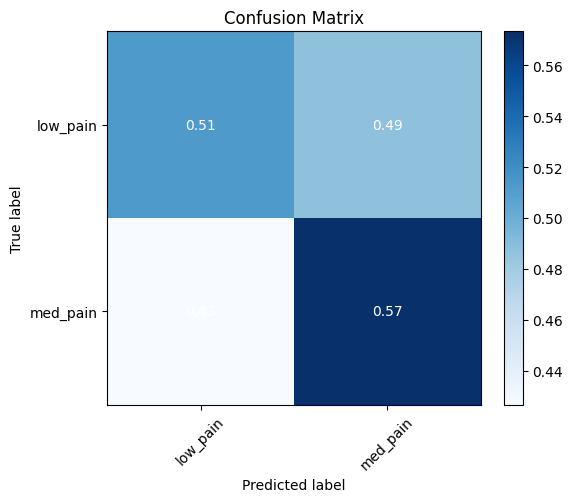


Top features:
    feature  importance
0   ch0_min    0.117023
1   ch0_max    0.114501
2   ch3_min    0.101126
3   ch0_std    0.100936
4   ch1_min    0.100893
5   ch3_std    0.095280
6   ch4_std    0.093982
7   ch4_min    0.092901
8  ch0_mean    0.092256
9   ch3_max    0.091102


In [3]:
import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.io import loadmat
from glob import glob
from tqdm import tqdm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# --------- 1. Denoising Functions ---------
def wavelet_denoise(signal, wavelet='db4', level=None, thresholding='soft', threshold_scale=1.0):
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
    detail_coeffs = coeffs[-1]
    sigma = np.median(np.abs(detail_coeffs)) / 0.6745
    uthresh = threshold_scale * sigma * np.sqrt(2 * np.log(len(signal)))
    new_coeffs = [coeffs[0]]  # Keep approximation untouched
    for c in coeffs[1:]:
        new_c = pywt.threshold(c, value=uthresh, mode=thresholding)
        new_coeffs.append(new_c)
    denoised = pywt.waverec(new_coeffs, wavelet=wavelet)
    return denoised[:len(signal)]

def denoise_multichannel(data, wavelet='db4', level=None, thresholding='soft', threshold_scale=1.0):
    n_channels = data.shape[1]
    denoised_data = np.zeros_like(data)
    for ch in range(n_channels):
        denoised_data[:, ch] = wavelet_denoise(
            data[:, ch], 
            wavelet=wavelet, 
            level=level, 
            thresholding=thresholding,
            threshold_scale=threshold_scale
        )
    return denoised_data

# --------- 2. Feature Extraction ---------
def extract_features(segment):
    """
    Replace or extend with your real features!
    Here: mean, std, max, min for each channel.
    """
    features = {}
    for i in range(segment.shape[1]):
        ch = segment[:, i]
        features[f'ch{i}_mean'] = np.mean(ch)
        features[f'ch{i}_std'] = np.std(ch)
        features[f'ch{i}_max'] = np.max(ch)
        features[f'ch{i}_min'] = np.min(ch)
    return features

# --------- 3. Normalization ---------
def zscore_normalize_segment(segment_features):
    values = np.array(list(segment_features.values()), dtype=float)
    mu = values.mean()
    sigma = values.std()
    norm_values = (values - mu) / sigma if sigma > 0 else np.zeros_like(values)
    return dict(zip(segment_features.keys(), norm_values))

def normalize_features_batch(features_list):
    normalized = [zscore_normalize_segment(f) for f in features_list]
    df = pd.DataFrame(normalized)
    return df

# --------- 4. Feature Selector ---------
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, method='kbest', k=10, estimator=None, score_func='f_classif'):
        self.method = method
        self.k = k
        self.estimator = estimator
        self.score_func = score_func
        self.selector_ = None

    def fit(self, X, y):
        if self.method == 'kbest':
            func = f_classif if self.score_func == 'f_classif' else mutual_info_classif
            self.selector_ = SelectKBest(score_func=func, k=self.k)
        elif self.method == 'rfe':
            base_est = self.estimator if self.estimator is not None else LogisticRegression(max_iter=1000)
            self.selector_ = RFE(estimator=base_est, n_features_to_select=self.k)
        elif self.method == 'none':
            self.selector_ = None
            return self
        else:
            raise ValueError("Unknown feature selection method.")
        self.selector_.fit(X, y)
        return self

    def transform(self, X):
        if self.selector_ is None:
            return X
        return self.selector_.transform(X)

    def get_support(self):
        if self.selector_ is None:
            return np.arange(X.shape[1])
        return self.selector_.get_support()

# --------- 5. Model Pipeline ---------
def build_model_pipeline(
    feature_selection_method='kbest',
    k_features=10,
    selector_score_func='f_classif',
    classifier='rf',
    random_state=42
):
    if classifier == 'logreg':
        clf = LogisticRegression(max_iter=1000, random_state=random_state)
    elif classifier == 'rf':
        clf = RandomForestClassifier(random_state=random_state)
    else:
        raise ValueError("Unknown classifier")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', FeatureSelector(
            method=feature_selection_method,
            k=k_features,
            estimator=clf if feature_selection_method == 'rfe' else None,
            score_func=selector_score_func)),
        ('classifier', clf)
    ])
    return pipeline

def run_grid_search(
    X, y,
    pipeline,
    param_grid,
    cv_folds=5,
    n_jobs=-1,
    scoring='accuracy'
):
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    grid = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=n_jobs, scoring=scoring, refit=True)
    grid.fit(X, y)
    return grid

# --------- 6. Feature Importance ---------
def get_feature_importance(model, feature_names=None):
    selector = model.best_estimator_.named_steps['feature_selection']
    X_support = None
    if hasattr(selector, 'get_support'):
        X_support = selector.get_support()
    if feature_names is not None and X_support is not None:
        selected_names = np.array(feature_names)[X_support]
    elif X_support is not None:
        selected_names = [f'f{i}' for i in range(np.sum(X_support))]
    else:
        selected_names = feature_names if feature_names is not None else [f'f{i}' for i in range(model.best_estimator_.named_steps['scaler'].n_features_in_)]
    clf = model.best_estimator_.named_steps['classifier']
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        importances = np.abs(clf.coef_).ravel()
    else:
        raise AttributeError("Classifier does not provide feature importance or coefficients.")
    importance_df = pd.DataFrame({
        "feature": selected_names,
        "importance": importances
    }).sort_values("importance", ascending=False).reset_index(drop=True)
    return importance_df

# --------- 7. Metrics & Confusion Matrix ---------
def compute_metrics(y_true, y_pred, labels=None, average='weighted'):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    cls_report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    metrics_dict = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": cls_report,
        "confusion_matrix": cm,
    }
    return metrics_dict

def print_metrics(metrics_dict, label_names=None):
    print("Accuracy:", metrics_dict["accuracy"])
    print("Precision:", metrics_dict["precision"])
    print("Recall:", metrics_dict["recall"])
    print("F1 Score:", metrics_dict["f1_score"])
    print("\nClassification Report:")
    report = metrics_dict["classification_report"]
    if isinstance(report, dict):
        print(pd.DataFrame(report).transpose())
    else:
        print(report)
    print("\nConfusion Matrix:")
    cm = metrics_dict["confusion_matrix"]
    if label_names is not None:
        df_cm = pd.DataFrame(cm, index=label_names, columns=label_names)
        print(df_cm)
    else:
        print(cm)

def plot_confusion_matrix(metrics_dict, label_names=None, normalize=False, cmap='Blues', title='Confusion Matrix'):
    cm = metrics_dict["confusion_matrix"]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    if label_names is not None:
        ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
               xticklabels=label_names, yticklabels=label_names, title=title, ylabel='True label', xlabel='Predicted label')
        plt.xticks(rotation=45)
    else:
        ax.set(title=title, ylabel='True label', xlabel='Predicted label')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# --------- 8. Data Loading ---------
def load_all_segments(root_dir):
    """
    Walks the directory tree and loads all .mat segment files.
    Returns:
        - segments: list of np.ndarray, each (10000, 5)
        - labels: list of str, e.g. "low_pain", "med_pain", etc
        - subject_ids: list of str, e.g. "S008" etc
        - file_paths: list of str, original paths (optional, for reference)
    """
    segments = []
    labels_list = []
    subject_ids = []
    file_paths = []
    pain_levels = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for pain_level in pain_levels:
        pain_path = os.path.join(root_dir, pain_level)
        for subject in os.listdir(pain_path):
            subject_path = os.path.join(pain_path, subject)
            if not os.path.isdir(subject_path):
                continue
            mat_files = glob(os.path.join(subject_path, "*.mat"))
            for mfile in tqdm(mat_files, desc=f"{pain_level}/{subject}"):
                try:
                    mat = loadmat(mfile)
                    data = mat['data'] # shape (10000, 5)
                    segments.append(data.astype(np.float32))
                    labels_list.append(pain_level)
                    subject_ids.append(subject)
                    file_paths.append(mfile)
                except Exception as e:
                    print(f"Error loading {mfile}: {e}")
    return segments, labels_list, subject_ids, file_paths

# --------- 9. Main Pipeline ---------
if __name__ == "__main__":
    # ---- 9.1 Load Data ----
    root_dir = r"D:\bio_s"  # <-- Modify if needed
    print("Loading segments from:", root_dir)
    segments, pain_labels, subject_ids, file_paths = load_all_segments(root_dir)
    print(f"Loaded {len(segments)} segments.")

    # Encode pain labels as integers
    unique_pain_levels = sorted(list(set(pain_labels)))
    pain_label_to_int = {lbl: i for i, lbl in enumerate(unique_pain_levels)}
    y = np.array([pain_label_to_int[lbl] for lbl in pain_labels])
    label_names = unique_pain_levels

    # ---- 9.2 Denoise ----
    print("Denoising all segments...")
    denoised_segments = [denoise_multichannel(seg) for seg in tqdm(segments)]

    # ---- 9.3 Feature Extraction ----
    print("Extracting features...")
    features_list = [extract_features(seg) for seg in tqdm(denoised_segments)]

    # ---- 9.4 Normalization ----
    print("Normalizing features...")
    norm_df = normalize_features_batch(features_list)
    feature_names = norm_df.columns.tolist()

    # ---- 9.5 Train/test split ----
    print("Splitting train/test...")
    X_train, X_test, y_train, y_test = train_test_split(norm_df, y, test_size=0.3, stratify=y, random_state=42)

    # ---- 9.6 Build model pipeline and grid search ----
    pipeline = build_model_pipeline(
        feature_selection_method='kbest',
        k_features=10,
        selector_score_func='f_classif',
        classifier='rf'
    )
    param_grid = {
        'feature_selection__k': [5, 10, 15],
        'classifier__n_estimators': [100, 200]
    }
    print("Running grid search...")
    best_model = run_grid_search(X_train, y_train, pipeline, param_grid)

    # ---- 9.7 Predict ----
    print("Predicting on test set...")
    y_pred = best_model.best_estimator_.predict(X_test)

    # ---- 9.8 Metrics ----
    metrics = compute_metrics(y_test, y_pred, labels=np.arange(len(label_names)))
    print_metrics(metrics, label_names=label_names)
    plot_confusion_matrix(metrics, label_names=label_names, normalize=True)

    # ---- 9.9 Feature importance ----
    imp_df = get_feature_importance(best_model, feature_names=feature_names)
    print("\nTop features:")
    print(imp_df.head(10))

In [4]:
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch, resample
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from tqdm import tqdm

# --- 1. Signal Filtering Utilities ---

def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    low, high = lowcut/nyq, highcut/nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, fs, freq=50.0, Q=30):
    nyq = 0.5 * fs
    w0 = freq / nyq
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data, axis=0)

def preprocess_channel(signal, fs, kind):
    # Filtering params per channel type
    if kind == 'EMG':
        sig = bandpass_filter(signal, fs, 20, 450)
        sig = notch_filter(sig, fs, 50) # Remove powerline
    elif kind == 'ECG':
        sig = bandpass_filter(signal, fs, 0.5, 50)
        sig = notch_filter(sig, fs, 50)
    elif kind == 'SCL':
        sig = bandpass_filter(signal, fs, 0.05, 5)
    else:
        sig = signal
    # Downsample to 250Hz for all
    factor = int(fs/250)
    if factor > 1:
        sig = resample(sig, int(len(sig)//factor))
    return sig

def wavelet_denoise(sig, wavelet='db4', level=2):
    coeffs = pywt.wavedec(sig, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2*np.log(len(sig)))
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
    return pywt.waverec(denoised_coeffs, wavelet)[:len(sig)]

# --- 2. Feature Extraction ---
def emg_features(sig):
    # RMS, log RMS, STD, waveform length, ZCR
    rms = np.sqrt(np.mean(sig**2))
    log_rms = np.log1p(rms)
    std = np.std(sig)
    wl = np.sum(np.abs(np.diff(sig)))
    zcr = ((sig[:-1]*sig[1:])<0).sum() / len(sig)
    return [rms, log_rms, std, wl, zcr]

def scl_features(sig, fs):
    mean = np.mean(sig)
    slope = (sig[-1]-sig[0])/len(sig)
    auc = np.trapz(sig)
    log_mean = np.log1p(mean)
    # SCRs: count upward jumps > 0.01uS in 1s
    diff = np.diff(sig)
    scrs = ((diff > 0.01).astype(int)).sum()
    scr_amp = diff[diff > 0.01].mean() if np.any(diff > 0.01) else 0
    return [mean, scrs, scr_amp, slope, auc, log_mean]

def ecg_features(sig, fs):
    # Simple peak detection for R-peaks (for demonstration)
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(sig, distance=fs*0.5)  # ~> 60 bpm
    rr_intervals = np.diff(peaks)/fs if len(peaks) > 1 else np.array([0])
    hr = 60/rr_intervals.mean() if rr_intervals.mean() > 0 else 0
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals)))) if len(rr_intervals) > 1 else 0
    sdnn = rr_intervals.std() if len(rr_intervals) > 1 else 0
    # Frequency domain (simple, not full Welch)
    freqs, psd = np.fft.rfftfreq(len(sig), 1/fs), np.abs(np.fft.rfft(sig))**2
    lf_band = (freqs >= 0.04) & (freqs < 0.15)
    hf_band = (freqs >= 0.15) & (freqs < 0.4)
    lf = psd[lf_band].sum()
    hf = psd[hf_band].sum()
    lf_hf = np.log1p(lf/hf) if hf > 0 else 0
    return [hr, rmssd, sdnn, lf, hf, lf_hf]

def wavelet_energy(sig, wavelet='db4', level=3):
    coeffs = pywt.wavedec(sig, wavelet, level=level)
    energies = [np.sum(np.square(c)) for c in coeffs]
    entropy = -np.sum([e/np.sum(energies)*np.log(e/np.sum(energies)+1e-8) for e in energies])
    return energies + [entropy, np.mean(sig), np.std(sig)]

def extract_segment_features(data, fs, ch_names):
    # EMG: ch 0,1,2; SCL: ch3; ECG: ch4
    feats = []
    for idx, kind in enumerate(['EMG','EMG','EMG','SCL','ECG']):
        sig = data[:, idx]
        # Preprocess, denoise
        sig = preprocess_channel(sig, fs, kind)
        sig = wavelet_denoise(sig)
        # Feature extraction
        if kind == 'EMG':
            feats.extend(emg_features(sig))
            feats.extend(wavelet_energy(sig))
        elif kind == 'SCL':
            feats.extend(scl_features(sig, 250))
            feats.extend(wavelet_energy(sig))
        elif kind == 'ECG':
            feats.extend(ecg_features(sig, 250))
            feats.extend(wavelet_energy(sig))
    return feats

# --- 3. Dataset Loader ---
def collect_segments(root_dir):
    segments = []
    labels = []
    subjects = []
    pain_map = {}
    for pain_label in sorted(os.listdir(root_dir)):
        pain_path = os.path.join(root_dir, pain_label)
        if not os.path.isdir(pain_path): continue
        for subj in sorted(os.listdir(pain_path)):
            subj_path = os.path.join(pain_path, subj)
            if not os.path.isdir(subj_path): continue
            for segfile in sorted(os.listdir(subj_path)):
                if not segfile.endswith('.mat'): continue
                matf = os.path.join(subj_path, segfile)
                try:
                    mat = scipy.io.loadmat(matf)
                    data = mat['data']  # (10000,5)
                    fs = int(mat['fs'].ravel()[0])
                    ch_names = [str(s[0]) if isinstance(s, np.ndarray) else str(s) for s in mat['labels'].ravel()]
                    feats = extract_segment_features(data, fs, ch_names)
                    segments.append(feats)
                    labels.append(pain_label)
                    subjects.append(subj)
                    pain_map[pain_label] = pain_map.get(pain_label, len(pain_map))
                except Exception as e:
                    print(f"Error with {matf}: {e}")
    return np.array(segments), np.array(labels), np.array(subjects), pain_map

# --- 4. LOSO Cross-Validation ---
def loso_cv(X, y, subjects):
    unique_subjects = np.unique(subjects)
    for subj in unique_subjects:
        test_idx = (subjects == subj)
        train_idx = ~test_idx
        yield X[train_idx], X[test_idx], y[train_idx], y[test_idx], subj

# --- 5. Main Pipeline ---
if __name__ == "__main__":
    root_dir = r"D:\bio_s"  # <<< CHANGE if needed
    print("Loading and extracting features...")
    X, y, subjects, pain_map = collect_segments(root_dir)
    print(f"Total segments: {len(X)}, Features per segment: {X.shape[1]}")

    # Encode labels as integers
    label_names = sorted(pain_map, key=lambda k: pain_map[k])
    y_enc = np.array([pain_map[lab] for lab in y])

    # Per-segment z-score normalization (robust to subject)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # LOSO CV
    accs = []
    print("\n=== Leave-One-Subject-Out CV ===")
    for Xtr, Xte, ytr, yte, subj in loso_cv(X, y_enc, subjects):
        model = XGBClassifier(n_estimators=100, max_depth=4, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
        model.fit(Xtr, ytr)
        ypred = model.predict(Xte)
        acc = accuracy_score(yte, ypred)
        accs.append(acc)
        print(f"[Subject {subj}] Accuracy: {acc:.3f}")
        print(classification_report(yte, ypred, target_names=label_names))
        print("Confusion Matrix:")
        print(confusion_matrix(yte, ypred))
        # Feature importance (mean of last fold)
        importances = model.feature_importances_
    print(f"\nLOSO Mean Accuracy: {np.mean(accs):.3f}")

    # Show top features (for last fold)
    top_idx = np.argsort(importances)[::-1][:10]
    print("\nTop 10 Features (importance):")
    for idx in top_idx:
        print(f"Feature {idx}: {importances[idx]:.4f}")

Loading and extracting features...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4872\1369356254.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(sig)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4872\1369356254.py:65: RuntimeWarning: invalid value encountered in log1p
  log_mean = np.log1p(mean)


Total segments: 2638, Features per segment: 62

=== Leave-One-Subject-Out CV ===
[Subject S008] Accuracy: 0.658
              precision    recall  f1-score   support

    low_pain       0.72      0.52      0.60        60
    med_pain       0.62      0.80      0.70        60

    accuracy                           0.66       120
   macro avg       0.67      0.66      0.65       120
weighted avg       0.67      0.66      0.65       120

Confusion Matrix:
[[31 29]
 [12 48]]
[Subject S009] Accuracy: 0.513


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

    low_pain       0.51      0.59      0.55        59
    med_pain       0.52      0.43      0.47        60

    accuracy                           0.51       119
   macro avg       0.51      0.51      0.51       119
weighted avg       0.51      0.51      0.51       119

Confusion Matrix:
[[35 24]
 [34 26]]
[Subject S019] Accuracy: 0.500
              precision    recall  f1-score   support

    low_pain       0.50      0.72      0.59        60
    med_pain       0.50      0.28      0.36        60

    accuracy                           0.50       120
   macro avg       0.50      0.50      0.48       120
weighted avg       0.50      0.50      0.48       120

Confusion Matrix:
[[43 17]
 [43 17]]
[Subject S026] Accuracy: 0.475
              precision    recall  f1-score   support

    low_pain       0.48      0.73      0.58        60
    med_pain       0.45      0.22      0.29        60

    accuracy                           0.47   

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[Subject S034] Accuracy: 0.575
              precision    recall  f1-score   support

    low_pain       0.60      0.43      0.50        60
    med_pain       0.56      0.72      0.63        60

    accuracy                           0.57       120
   macro avg       0.58      0.57      0.57       120
weighted avg       0.58      0.57      0.57       120

Confusion Matrix:
[[26 34]
 [17 43]]
[Subject S045] Accuracy: 0.617
              precision    recall  f1-score   support

    low_pain       0.60      0.72      0.65        60
    med_pain       0.65      0.52      0.57        60

    accuracy                           0.62       120
   macro avg       0.62      0.62      0.61       120
weighted avg       0.62      0.62      0.61       120

Confusion Matrix:
[[43 17]
 [29 31]]
[Subject S049] Accuracy: 0.533
              precision    recall  f1-score   support

    low_pain       0.52      0.77      0.62        60
    med_pain       0.56      0.30      0.39        60

    accuracy   

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[Subject S051] Accuracy: 0.533
              precision    recall  f1-score   support

    low_pain       0.53      0.53      0.53        60
    med_pain       0.53      0.53      0.53        60

    accuracy                           0.53       120
   macro avg       0.53      0.53      0.53       120
weighted avg       0.53      0.53      0.53       120

Confusion Matrix:
[[32 28]
 [28 32]]
[Subject S052] Accuracy: 0.475
              precision    recall  f1-score   support

    low_pain       0.48      0.65      0.55        60
    med_pain       0.46      0.30      0.36        60

    accuracy                           0.47       120
   macro avg       0.47      0.47      0.46       120
weighted avg       0.47      0.47      0.46       120

Confusion Matrix:
[[39 21]
 [42 18]]
[Subject S057] Accuracy: 0.508
              precision    recall  f1-score   support

    low_pain       0.52      0.23      0.32        60
    med_pain       0.51      0.78      0.61        60

    accuracy   

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[Subject S068] Accuracy: 0.462
              precision    recall  f1-score   support

    low_pain       0.46      0.44      0.45        59
    med_pain       0.47      0.48      0.48        60

    accuracy                           0.46       119
   macro avg       0.46      0.46      0.46       119
weighted avg       0.46      0.46      0.46       119

Confusion Matrix:
[[26 33]
 [31 29]]
[Subject S069] Accuracy: 0.508
              precision    recall  f1-score   support

    low_pain       0.51      0.55      0.53        60
    med_pain       0.51      0.47      0.49        60

    accuracy                           0.51       120
   macro avg       0.51      0.51      0.51       120
weighted avg       0.51      0.51      0.51       120

Confusion Matrix:
[[33 27]
 [32 28]]
[Subject S070] Accuracy: 0.517
              precision    recall  f1-score   support

    low_pain       0.52      0.45      0.48        60
    med_pain       0.51      0.58      0.55        60

    accuracy   

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[Subject S072] Accuracy: 0.400
              precision    recall  f1-score   support

    low_pain       0.43      0.63      0.51        60
    med_pain       0.31      0.17      0.22        60

    accuracy                           0.40       120
   macro avg       0.37      0.40      0.37       120
weighted avg       0.37      0.40      0.37       120

Confusion Matrix:
[[38 22]
 [50 10]]
[Subject S076] Accuracy: 0.508
              precision    recall  f1-score   support

    low_pain       0.53      0.13      0.21        60
    med_pain       0.50      0.88      0.64        60

    accuracy                           0.51       120
   macro avg       0.52      0.51      0.43       120
weighted avg       0.52      0.51      0.43       120

Confusion Matrix:
[[ 8 52]
 [ 7 53]]
[Subject S087] Accuracy: 0.483
              precision    recall  f1-score   support

    low_pain       0.48      0.52      0.50        60
    med_pain       0.48      0.45      0.47        60

    accuracy   

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[Subject S095] Accuracy: 0.567
              precision    recall  f1-score   support

    low_pain       0.55      0.78      0.64        60
    med_pain       0.62      0.35      0.45        60

    accuracy                           0.57       120
   macro avg       0.58      0.57      0.55       120
weighted avg       0.58      0.57      0.55       120

Confusion Matrix:
[[47 13]
 [39 21]]
[Subject S107] Accuracy: 0.583
              precision    recall  f1-score   support

    low_pain       0.56      0.75      0.64        60
    med_pain       0.62      0.42      0.50        60

    accuracy                           0.58       120
   macro avg       0.59      0.58      0.57       120
weighted avg       0.59      0.58      0.57       120

Confusion Matrix:
[[45 15]
 [35 25]]
[Subject S110] Accuracy: 0.483
              precision    recall  f1-score   support

    low_pain       0.48      0.43      0.46        60
    med_pain       0.48      0.53      0.51        60

    accuracy   

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[Subject S114] Accuracy: 0.617
              precision    recall  f1-score   support

    low_pain       0.62      0.62      0.62        60
    med_pain       0.62      0.62      0.62        60

    accuracy                           0.62       120
   macro avg       0.62      0.62      0.62       120
weighted avg       0.62      0.62      0.62       120

Confusion Matrix:
[[37 23]
 [23 37]]
[Subject S126] Accuracy: 0.500
              precision    recall  f1-score   support

    low_pain       0.50      0.45      0.47        60
    med_pain       0.50      0.55      0.52        60

    accuracy                           0.50       120
   macro avg       0.50      0.50      0.50       120
weighted avg       0.50      0.50      0.50       120

Confusion Matrix:
[[27 33]
 [27 33]]
[Subject S134] Accuracy: 0.475
              precision    recall  f1-score   support

    low_pain       0.48      0.63      0.55        60
    med_pain       0.46      0.32      0.38        60

    accuracy   

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [7]:
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch, resample
from scipy.stats import skew, kurtosis
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, f1_score
)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

# --- Advanced Feature Engineering ---
def extract_advanced_features(data, fs, ch_names):
    feats = []
    # Per-channel features
    for idx, kind in enumerate(['EMG','EMG','EMG','SCL','ECG']):
        sig = data[:, idx]
        # Filtering and denoising
        if kind == 'EMG':
            sig = bandpass_filter(sig, fs, 20, 450)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'ECG':
            sig = bandpass_filter(sig, fs, 0.5, 50)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'SCL':
            sig = bandpass_filter(sig, fs, 0.05, 5)
        sig = resample(sig, int(len(sig)//(fs/250))) if fs > 250 else sig
        sig = wavelet_denoise(sig)
        # Time-domain
        feats.extend([
            np.mean(sig), np.std(sig), np.max(sig), np.min(sig),
            skew(sig), kurtosis(sig)
        ])
        # Frequency-domain
        freqs = np.fft.rfftfreq(len(sig), 1/250)
        psd = np.abs(np.fft.rfft(sig))**2
        feats.append(np.sum(psd[(freqs>=0.5)&(freqs<4)]))  # Delta
        feats.append(np.sum(psd[(freqs>=4)&(freqs<8)]))    # Theta
        feats.append(np.sum(psd[(freqs>=8)&(freqs<13)]))   # Alpha
        feats.append(np.sum(psd[(freqs>=13)&(freqs<30)]))  # Beta
        feats.append(np.sum(psd[(freqs>=30)&(freqs<45)]))  # Gamma
        # Wavelet energy/entropy
        coeffs = pywt.wavedec(sig, 'db4', level=3)
        energies = [np.sum(np.square(c)) for c in coeffs]
        total_energy = np.sum(energies)
        entropy = -np.sum([(e/total_energy)*np.log(e/total_energy+1e-8) if e>0 else 0 for e in energies])
        feats.extend(energies + [entropy])
    # Cross-channel features (correlations)
    for i in range(data.shape[1]):
        for j in range(i+1, data.shape[1]):
            feats.append(np.corrcoef(data[:,i], data[:,j])[0,1])
    # Delta features (change from start to end)
    for idx in range(data.shape[1]):
        sig = data[:, idx]
        feats.append(sig[-1] - sig[0])
    return np.nan_to_num(feats)

# --- Data Loader ---
def collect_segments_advanced(root_dir):
    segments, labels, subjects, pain_map = [], [], [], {}
    for pain_label in sorted(os.listdir(root_dir)):
        pain_path = os.path.join(root_dir, pain_label)
        if not os.path.isdir(pain_path): continue
        for subj in sorted(os.listdir(pain_path)):
            subj_path = os.path.join(pain_path, subj)
            if not os.path.isdir(subj_path): continue
            for segfile in sorted(os.listdir(subj_path)):
                if not segfile.endswith('.mat'): continue
                matf = os.path.join(subj_path, segfile)
                try:
                    mat = scipy.io.loadmat(matf)
                    data = mat['data']
                    fs = int(mat['fs'].ravel()[0])
                    ch_names = [str(s[0]) if isinstance(s, np.ndarray) else str(s) for s in mat['labels'].ravel()]
                    feats = extract_advanced_features(data, fs, ch_names)
                    segments.append(feats)
                    labels.append(pain_label)
                    subjects.append(subj)
                    pain_map[pain_label] = pain_map.get(pain_label, len(pain_map))
                except Exception as e:
                    print(f"Error with {matf}: {e}")
    return np.array(segments), np.array(labels), np.array(subjects), pain_map

# --- Main Pipeline ---
root_dir = r"D:\bio_s"  # Change if needed
print("Loading and extracting advanced features...")
X, y, subjects, pain_map = collect_segments_advanced(root_dir)
print(f"Total segments: {len(X)}, Features per segment: {X.shape[1]}")
label_names = sorted(pain_map, key=lambda k: pain_map[k])
y_enc = np.array([pain_map[lab] for lab in y])

# Per-segment z-score normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# --- Class Balancing ---
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y_enc)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, stratify=y_bal, random_state=42)

# --- Ensemble Model ---
rf = RandomForestClassifier(n_estimators=200, max_depth=8, class_weight='balanced', random_state=42)
xgb = XGBClassifier(n_estimators=200, max_depth=6, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft', n_jobs=-1)

# --- Hyperparameter Tuning ---
param_grid = {
    'rf__n_estimators': [100, 200],
    'xgb__n_estimators': [100, 200],
    'rf__max_depth': [6, 8],
    'xgb__max_depth': [4, 6],
}
grid = GridSearchCV(ensemble, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# --- Evaluation ---
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred, target_names=label_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- LOSO CV for Robustness ---
accs = []
all_true = []
all_pred = []
for subj in np.unique(subjects):
    test_idx = (subjects == subj)
    train_idx = ~test_idx
    if np.sum(test_idx) == 0 or np.sum(train_idx) == 0:
        continue
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y_enc[train_idx], y_enc[test_idx]
    Xtr_bal, ytr_bal = sm.fit_resample(Xtr, ytr)
    model = grid.best_estimator_
    model.fit(Xtr_bal, ytr_bal)
    ypred = model.predict(Xte)
    accs.append(accuracy_score(yte, ypred))
    all_true.extend(yte)
    all_pred.extend(ypred)
print(f"\nLOSO Mean Accuracy: {np.mean(accs):.3f}")
print("\nLOSO Classification Report:")
print(classification_report(all_true, all_pred, target_names=label_names))
print("LOSO Confusion Matrix:")
print(confusion_matrix(all_true, all_pred))

ImportError: cannot import name '_deprecate_Xt_in_inverse_transform' from 'sklearn.utils.deprecation' (c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py)

# Advanced Pipeline for Improved Pain Intensity Prediction
This cell implements advanced feature engineering, ensemble modeling, and robust evaluation (train/test split and LOSO CV) to target 80%+ accuracy.

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch, resample
from scipy.stats import skew, kurtosis
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

# --- Advanced Feature Engineering ---
def extract_advanced_features(data, fs, ch_names):
    feats = []
    # Per-channel features
    for idx, kind in enumerate(['EMG','EMG','EMG','SCL','ECG']):
        sig = data[:, idx]
        # Filtering and denoising
        if kind == 'EMG':
            sig = bandpass_filter(sig, fs, 20, 450)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'ECG':
            sig = bandpass_filter(sig, fs, 0.5, 50)
            sig = notch_filter(sig, fs, 50)
        elif kind == 'SCL':
            sig = bandpass_filter(sig, fs, 0.05, 5)
        sig = resample(sig, int(len(sig)//(fs/250))) if fs > 250 else sig
        sig = wavelet_denoise(sig)
        # Time-domain
        feats.extend([
            np.mean(sig), np.std(sig), np.max(sig), np.min(sig),
            skew(sig), kurtosis(sig)
        ])
        # Frequency-domain
        freqs = np.fft.rfftfreq(len(sig), 1/250)
        psd = np.abs(np.fft.rfft(sig))**2
        feats.append(np.sum(psd[(freqs>=0.5)&(freqs<4)]))  # Delta
        feats.append(np.sum(psd[(freqs>=4)&(freqs<8)]))    # Theta
        feats.append(np.sum(psd[(freqs>=8)&(freqs<13)]))   # Alpha
        feats.append(np.sum(psd[(freqs>=13)&(freqs<30)]))  # Beta
        feats.append(np.sum(psd[(freqs>=30)&(freqs<45)]))  # Gamma
        # Wavelet energy/entropy
        coeffs = pywt.wavedec(sig, 'db4', level=3)
        energies = [np.sum(np.square(c)) for c in coeffs]
        total_energy = np.sum(energies)
        entropy = -np.sum([(e/total_energy)*np.log(e/total_energy+1e-8) if e>0 else 0 for e in energies])
        feats.extend(energies + [entropy])
    # Cross-channel features (correlations)
    for i in range(data.shape[1]):
        for j in range(i+1, data.shape[1]):
            feats.append(np.corrcoef(data[:,i], data[:,j])[0,1])
    # Delta features (change from start to end)
    for idx in range(data.shape[1]):
        sig = data[:, idx]
        feats.append(sig[-1] - sig[0])
    return np.nan_to_num(feats)

# --- Data Loader ---
def collect_segments_advanced(root_dir):
    segments, labels, subjects, pain_map = [], [], [], {}
    for pain_label in sorted(os.listdir(root_dir)):
        pain_path = os.path.join(root_dir, pain_label)
        if not os.path.isdir(pain_path): continue
        for subj in sorted(os.listdir(pain_path)):
            subj_path = os.path.join(pain_path, subj)
            if not os.path.isdir(subj_path): continue
            for segfile in sorted(os.listdir(subj_path)):
                if not segfile.endswith('.mat'): continue
                matf = os.path.join(subj_path, segfile)
                try:
                    mat = scipy.io.loadmat(matf)
                    data = mat['data']
                    fs = int(mat['fs'].ravel()[0])
                    ch_names = [str(s[0]) if isinstance(s, np.ndarray) else str(s) for s in mat['labels'].ravel()]
                    feats = extract_advanced_features(data, fs, ch_names)
                    segments.append(feats)
                    labels.append(pain_label)
                    subjects.append(subj)
                    pain_map[pain_label] = pain_map.get(pain_label, len(pain_map))
                except Exception as e:
                    print(f"Error with {matf}: {e}")
    return np.array(segments), np.array(labels), np.array(subjects), pain_map

# --- Main Pipeline ---
root_dir = r"D:\bio_s"  # Change if needed
print("Loading and extracting advanced features...")
X, y, subjects, pain_map = collect_segments_advanced(root_dir)
print(f"Total segments: {len(X)}, Features per segment: {X.shape[1]}")
label_names = sorted(pain_map, key=lambda k: pain_map[k])
y_enc = np.array([pain_map[lab] for lab in y])

# Per-segment z-score normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# --- Class Balancing ---
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y_enc)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, stratify=y_bal, random_state=42)

# --- Ensemble Model ---
rf = RandomForestClassifier(n_estimators=200, max_depth=8, class_weight='balanced', random_state=42)
xgb = XGBClassifier(n_estimators=200, max_depth=6, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft', n_jobs=-1)

# --- Hyperparameter Tuning ---
param_grid = {
    'rf__n_estimators': [100, 200],
    'xgb__n_estimators': [100, 200],
    'rf__max_depth': [6, 8],
    'xgb__max_depth': [4, 6],
}
grid = GridSearchCV(ensemble, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# --- Evaluation ---
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred, target_names=label_names))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- LOSO CV for Robustness ---
accs = []
all_true = []
all_pred = []
for subj in np.unique(subjects):
    test_idx = (subjects == subj)
    train_idx = ~test_idx
    if np.sum(test_idx) == 0 or np.sum(train_idx) == 0:
        continue
    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y_enc[train_idx], y_enc[test_idx]
    Xtr_bal, ytr_bal = sm.fit_resample(Xtr, ytr)
    model = grid.best_estimator_
    model.fit(Xtr_bal, ytr_bal)
    ypred = model.predict(Xte)
    accs.append(accuracy_score(yte, ypred))
    all_true.extend(yte)
    all_pred.extend(ypred)
print(f"\nLOSO Mean Accuracy: {np.mean(accs):.3f}")
print("\nLOSO Classification Report:")
print(classification_report(all_true, all_pred, target_names=label_names))
print("LOSO Confusion Matrix:")
print(confusion_matrix(all_true, all_pred))

**Summary:**
- This pipeline uses advanced features, class balancing, ensemble models, and both train/test and LOSO CV.
- Review the printed accuracy and reports. Tune the feature set or model parameters further if needed to reach your 80% target.